In [106]:
# Set up the look of plots
import seaborn as sns
sns.set_style(rc={'font.family': ['sans-serif'],'axis.labelsize': 25})
sns.set_context("notebook")

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import cumtrapz
from IPython.display import Image
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.labelsize'] = 18

# Spindown rates from switching models of pulsars
 
For several pulsars, their spin-down rates demonstrate a double-peaked shape. A noteable example of this is B1828-11. Below we reproduce the spin-down rate for B1828-11 with data generously provided by [Lyne et. al. (2010)](http://adsabs.harvard.edu/abs/2010Sci...329..408L).

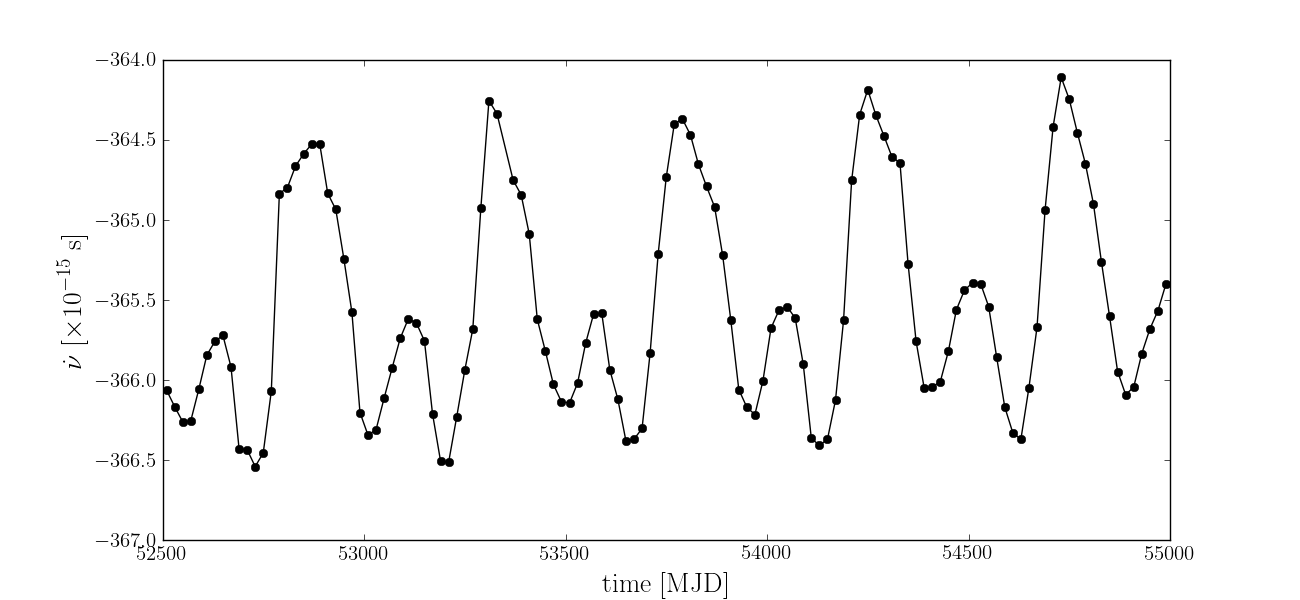

In [43]:
Image("../images/SpindownData_B1828-11.png", width=700)

The mechanism proposed by these authors is that the spin-down rate switches suddenly between two distinct states. The sliding window used to calculate the spin-rate causes the smoothing of the data to that observeed. In order to explain the two peaks [Perera at a. (2014)](http://adsabs.harvard.edu/abs/2015MNRAS.446.1380P) realised the switching needed to occur twice in a single cycle. The second peak is smaller because the time-averaging window is longer than the time spent in one state. To illustrate we will plot the underlying model along with the time averaged values.

First we define some helper functions, `Perera()` produces the underlying model, the `SignalModel` produces the time averaged spin-down,

In [66]:

def Perera(time, nudot1, nudot2, nuddot, T, tAB, tBC, tCD, phi0):
    Spindown = np.zeros(len(time)) + nudot1

    ti_mod = np.mod(time + phi0*T, T)
    Spindown[(tAB < ti_mod) & (ti_mod < tAB+tBC)] = nudot2
    Spindown[tAB + tBC + tCD < ti_mod] = nudot2
    Spindown = Spindown + nuddot * time
    
    return Spindown


def PhaseFromSpindown(time, F1):

    F0 = cumtrapz(y=F1, x=time, initial=0)

    P0 = 2 * np.pi * cumtrapz(y=F0, x=time, initial=0)

    return P0


def SpindownFromPhase(sampling_times, time, Phase, DeltaT=100, frac=0.25):

    dt = time[1] - time[0]
    DeltaT_idx = int(DeltaT / dt)
    DeltaT_idx += DeltaT_idx % 2  # Make it even

    tref = time[0]
    timeprime = time - tref

    idxs = closest_idxs(time, sampling_times)

    vert_idx_list = idxs
    hori_idx_list = np.arange(-DeltaT_idx/2, DeltaT_idx/2)
    A, B = np.meshgrid(hori_idx_list, vert_idx_list)
    idx_array = A + B

    timeprime_array = timeprime[idx_array]

    Phase_array = Phase[idx_array]

    F1 = np.polynomial.polynomial.polyfit(timeprime_array[0],
                                          Phase_array.T, 2)[2, :]/np.pi

    return sampling_times, F1


def closest_idxs(array, points):
    """ Closests indexes of points in array

    Note: If the array is too large, this can quickly crash the system
    """
    points = points.reshape(len(points), 1)
    deltas = np.abs(points - array)
    return np.argmin(deltas, axis=1)


def SignalModel(time, nudot1, nudot2, nuddot, T, tAB, tBC, tCD, phi0, DeltaT):
    sampling_times = time

    Nfine = 1000
    frac = 0.25  # Fraction to shift by

    time_fine = np.linspace(time[0]-DeltaT/2., time[-1]+DeltaT/2., Nfine)
    spindown = Perera(time_fine, nudot1, nudot2, nuddot, T, tAB, tBC, tCD,
                      phi0)
    phase = PhaseFromSpindown(time_fine, spindown)
    time_ave, spindown_ave = SpindownFromPhase(sampling_times,
                                               time_fine,
                                               phase,
                                               DeltaT, frac)

    return spindown_ave

Okay, so lets show the difference with some typical values

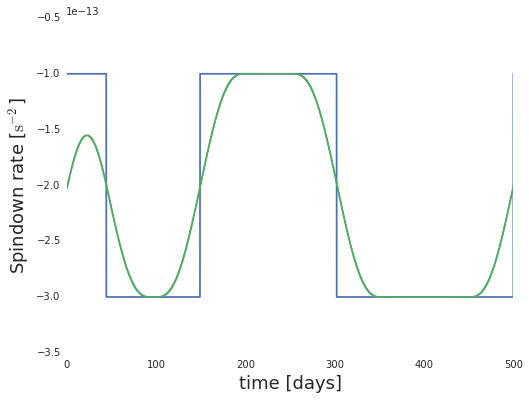

In [112]:
nudot1 = -1e-13
nudot2 = -3e-13
T = 500*86400.
tAB = 44*86400.
tBC = 105*86400.
tCD = 153*86400.
nuddot = 0
phi0 = 0

time = np.linspace(0, 500*86400, 10000)

UnderLyingSpindown = Perera(time, nudot1, nudot2, nuddot, T, tAB, tBC, tCD, phi0)

DeltaT = 100*86400
ObservedSpindown = SignalModel(time, nudot1, nudot2, nuddot, T, tAB, tBC, tCD, phi0, DeltaT)

fig, ax1 = plt.subplots()
ax1.plot(time/86400., UnderLyingSpindown)
ax1.plot(time/86400., ObservedSpindown)

ax1.set_ylabel("Spindown rate [$\mathrm{s}^{-2}$]")
ax1.set_xlabel("time [days]")

plt.show()

So we can measure the two values at the shorter peak quite simply by picking the correct point. We now create a helper function
to automate this process and then show the measured value:

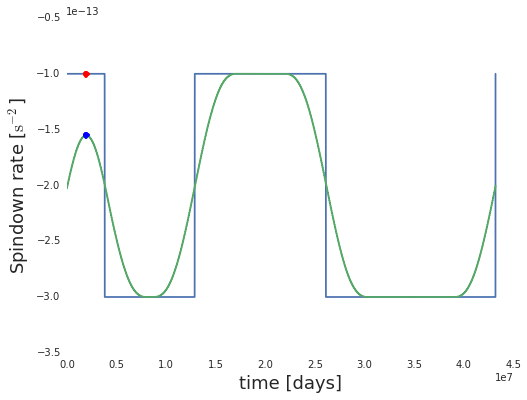

In [113]:
idx_to_measure = np.argmin(np.abs(time - tAB/2.))

def MeasureHeightsAtShorterSwitch(DeltaT):
    UnderLyingSpindown = Perera(time, nudot1, nudot2, nuddot, T, tAB, tBC, tCD, phi0)
    ObservedSpindown = SignalModel(time, nudot1, nudot2, nuddot, T, tAB, tBC, tCD, phi0, DeltaT)
    return UnderLyingSpindown[idx_to_measure], ObservedSpindown[idx_to_measure]

obsH, actH = MeasureHeightsAtShorterSwitch(DeltaT)

fig, ax1 = plt.subplots()
ax1.plot(time, UnderLyingSpindown)
ax1.plot(time, ObservedSpindown)

ax1.plot(time[idx_to_measure], obsH, "or")
ax1.plot(time[idx_to_measure], actH, "ob")

ax1.set_ylabel("Spindown rate [$\mathrm{s}^{-2}$]")
ax1.set_xlabel("time [days]")
plt.show()

So now we will look at how this ratio changes based on `DeltaT` the averaging time-length

In [92]:
DeltaT_list = np.linspace(10*86400, 500*86400, 100)

ratio = []
for DeltaT in DeltaT_list:
    obsH, actH = MeasureHeightsAtShorterSwitch(DeltaT)
    ratio.append(obsH/actH)

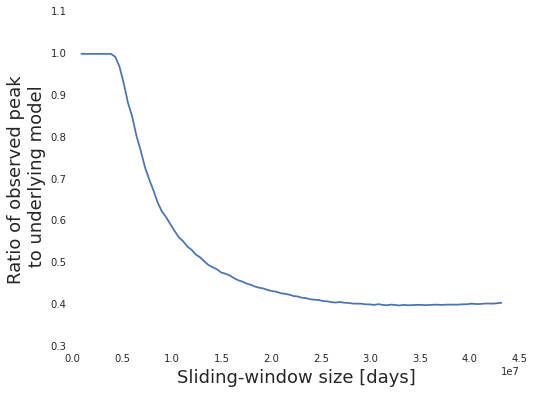

In [116]:
ax = plt.subplot(111)
ax.plot(DeltaT_list, ratio, "-")

ax.set_ylabel("Ratio of observed peak \n to underlying model")
ax.set_xlabel("Sliding-window size [days]")

plt.show()